In [471]:
import os
import pandas as pd 
import numpy as np 
import tensorflow as tf 
import scipy.stats as stats
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Dense, LSTM, Dropout, Conv2D, Lambda, Input
from tensorflow.keras import optimizers
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder,StandardScaler,OneHotEncoder
from sklearn.metrics._classification import precision_score, recall_score, f1_score

In [472]:
path_data = r"D:\bangkit\capstone\Family_health_Tracker\ML_workspace\daily_activity\cleaned_data_edit.csv"

In [473]:
data = pd.read_csv(path_data)
data.head()

,activity,x,y,z,numeric_label
0,A,6.188597,8.814006,10.455713,9
1,A,3.605272,10.013322,8.263343,9
2,A,4.606045,11.376722,8.513901,9
3,A,2.718174,13.761097,5.978487,9
4,A,1.299151,14.153046,3.168536,9


In [474]:
label = LabelEncoder()
data['label'] = label.fit_transform(data['activity']) 
data = data.drop('numeric_label',axis=1)
data

,activity,x,y,z,label
0,A,6.188597,8.814006,10.455713,0
1,A,3.605272,10.013322,8.263343,0
2,A,4.606045,11.376722,8.513901,0
3,A,2.718174,13.761097,5.978487,0
4,A,1.299151,14.153046,3.168536,0
...,...,...,...,...,...
71995,Q,8.595410,-1.557273,13.278905,8
71996,Q,11.872968,-17.995435,15.553696,8
71997,Q,1.515375,-18.559740,13.755783,8
71998,Q,-5.602373,-11.008275,12.288358,8


In [475]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 72000 entries, 0 to 71999
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   activity  72000 non-null  object 
 1   x         72000 non-null  float64
 2   y         72000 non-null  float64
 3   z         72000 non-null  float64
 4   label     72000 non-null  int64  
dtypes: float64(3), int64(1), object(1)
memory usage: 2.7+ MB


In [476]:
scaler = StandardScaler()
x = data[['x','y','z']]
y = data['label']

x =scaler.fit_transform(x)

sca_x = pd.DataFrame(data=x, columns=['x','y','z'])
sca_x['label'] = y.values
sca_x

,x,y,z,label
0,0.423709,0.733999,0.950354,0
1,0.116152,0.879255,0.639400,0
2,0.235299,1.044386,0.674938,0
3,0.010539,1.333173,0.315328,0
4,-0.158402,1.380644,-0.083221,0
...,...,...,...,...
71995,0.710251,-0.522134,1.350781,8
71996,1.100459,-2.513066,1.673426,8
71997,-0.132659,-2.581413,1.418419,8
71998,-0.980060,-1.666806,1.210287,8


In [477]:
Fs=20
frame_size = Fs*4 
hop_size = Fs*2

In [478]:
def get_frames(df, frame_size, hop_size):
    encoder = OneHotEncoder(sparse_output=False)
    N_FEATURES = 3
    frames = []
    labels = []
    for i in range(0,len(df )- frame_size, hop_size):
        x = df['x'].values[i: i+frame_size]
        y = df['y'].values[i: i+frame_size]
        z = df['z'].values[i: i+frame_size]
        
        label = stats.mode(df['label'][i: i+frame_size])[0]
        frames.append([x,y,z])
        labels.append(label)
        
    frames = np.asarray(frames).reshape(-1, frame_size, N_FEATURES)
    frames = np.expand_dims(frames,axis=1)
    labels = np.asarray(labels).reshape(-1,1)
    labels = encoder.fit_transform(labels)
    
    return frames, labels

x,y = get_frames(sca_x, frame_size, hop_size)
x.shape, y.shape

((1798, 1, 80, 3), (1798, 9))

In [479]:
x_train, x_test, y_train, y_test = train_test_split(x,y,test_size=0.30, random_state = 0, stratify = y)

In [480]:
model = Sequential()
model.add(Conv2D(3,kernel_size=(1,x_train.shape[3]),activation='relu',strides=(1, 1), padding='valid', \
    data_format="channels_last", input_shape=(x_train.shape[2], x_train.shape[3], 1)))
model.add(Lambda(lambda x: K.squeeze(x,axis=2)))
model.add(LSTM(32,return_sequences=False))
model.add(Dropout(rate=0.1))
model.add(Dense(9,activation='softmax'))

model.summary()


c:\Users\Lenovo\miniconda3\envs\Bangkit-env\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_71"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_70 (Conv2D)              │ (None, 80, 1, 3)       │            12 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lambda_53 (Lambda)              │ (None, 80, 3)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_52 (LSTM)                  │ (None, 32)             │         4,608 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_55 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_52 (Dense)                │ (None, 9)              │           297 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,917 (19.21 KB)

 Trainable params: 4,917 (19.21 KB)

 Non-trainable params: 0 (0.00 B)

In [481]:
opt = optimizers.Adam(clipnorm=1.)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=["accuracy"])

In [482]:
print(x_train.shape, x_test.shape)
print(y_train.shape, y_test.shape)

(1258, 1, 80, 3) (540, 1, 80, 3)
(1258, 9) (540, 9)


In [483]:
x_train = np.squeeze(x_train,axis=1)
x_test = np.squeeze(x_test,axis=1)

In [484]:
model_filename = 'model.keras'
callbacks = [ModelCheckpoint(filepath=model_filename, monitor='val_accuracy', save_best_only=True),
            EarlyStopping(monitor='val_accuracy', patience=20)]

history = model.fit(x_train, y_train, epochs=25,verbose=1, callbacks=callbacks, validation_data=(x_test, y_test))


Epoch 1/25
40/40 ━━━━━━━━━━━━━━━━━━━━ 4s 36ms/step - accuracy: 0.1312 - loss: 2.1746 - val_accuracy: 0.2315 - val_loss: 2.0624
Epoch 2/25
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - accuracy: 0.2392 - loss: 2.0179 - val_accuracy: 0.3148 - val_loss: 1.7889
Epoch 3/25
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.3562 - loss: 1.7454 - val_accuracy: 0.4056 - val_loss: 1.6034
Epoch 4/25
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.4136 - loss: 1.5427 - val_accuracy: 0.4500 - val_loss: 1.5005
Epoch 5/25
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - accuracy: 0.5148 - loss: 1.3715 - val_accuracy: 0.6185 - val_loss: 1.1861
Epoch 6/25
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.6060 - loss: 1.1900 - val_accuracy: 0.6370 - val_loss: 1.0817
Epoch 7/25
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - accuracy: 0.6275 - loss: 1.0803 - val_accuracy: 0.6889 - val_loss: 0.9576
Epoch 8/25
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.6578 - loss: 1.0122 - val_accuracy: 0.7148 - v

In [485]:
test_loss, test_accuracy = model.evaluate(x_test, y_test, verbose=1)

print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")


17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8263 - loss: 0.5054
Test Loss: 0.5154047608375549
Test Accuracy: 0.8314814567565918


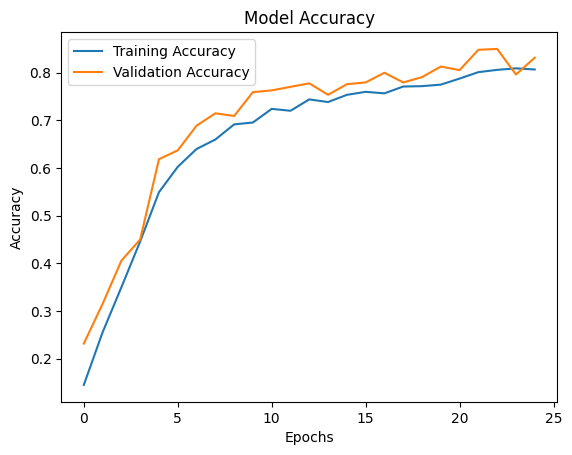

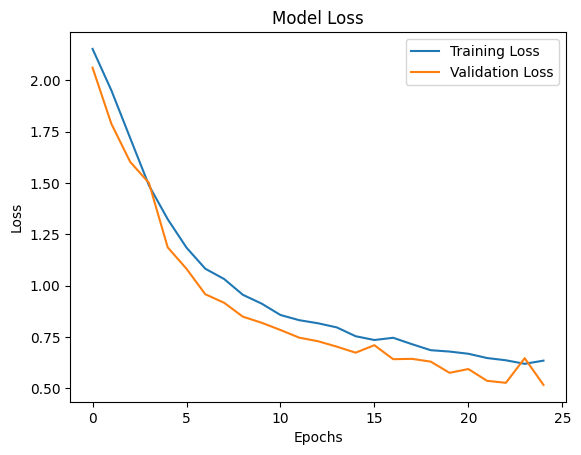

In [486]:
import matplotlib.pyplot as plt

# Ambil data history selama pelatihan
history_dict = history.history

# Plot akurasi
plt.plot(history_dict['accuracy'], label='Training Accuracy')
plt.plot(history_dict['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot kerugian
plt.plot(history_dict['loss'], label='Training Loss')
plt.plot(history_dict['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [487]:
model.save('best_model.h5',save_format = 'h5')

In [493]:
class_names = [
    'Walking',  # A
    'Jogging',  # B
    'Stairs',   # C
    'Sitting',  # D
    'Standing', # E
    'Kicking Soccer Ball', # M
    'Playing Catch w/Tennis Ball', # O
    'Dribbling Basketball',  # P
    'Writing',  # Q
]


In [ ]:
from sklearn.metrics import classification_report

# Prediksi pada data uji
y_pred = model.predict(x_test)
y_pred_classes = y_pred.argmax(axis=1)  # Konversi probabilitas ke kelas prediksi
y_true_classes = y_test.argmax(axis=1)  # Konversi one-hot ke kelas asli

# Laporan performa (precision, recall, f1-score)
report = classification_report(y_true_classes, y_pred_classes, target_names=class_names)
print("Classification Report:")
print(report)

17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
Classification Report:
                             precision    recall  f1-score   support

                    Walking       0.69      0.63      0.66        60
                    Jogging       0.93      0.88      0.91        60
                     Stairs       0.77      0.95      0.85        60
                    Sitting       0.98      1.00      0.99        60
                   Standing       0.98      1.00      0.99        60
        Kicking Soccer Ball       0.81      0.50      0.62        60
Playing Catch w/Tennis Ball       0.80      0.85      0.82        60
       Dribbling Basketball       0.59      0.73      0.66        60
                    Writing       0.98      0.93      0.96        60

                   accuracy                           0.83       540
                  macro avg       0.84      0.83      0.83       540
               weighted avg       0.84      0.83      0.83       540



17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


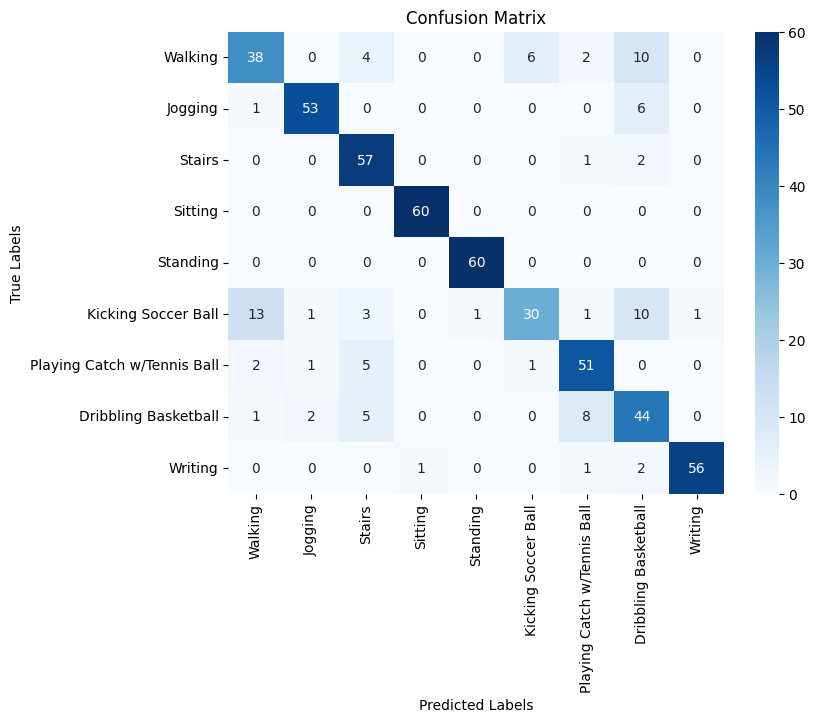

In [495]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Prediksi kelas
y_pred_classes = model.predict(x_test).argmax(axis=1)  # Konversi ke kelas
y_true_classes = y_test.argmax(axis=1)

# Hitung confusion matrix
cm = confusion_matrix(y_true_classes, y_pred_classes)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()
